In [1]:
import matplotlib.pyplot as plt
import numpy as np

import statcontracts.optimize
from notebook_env import *
from tqdm import tqdm
import json

## Prepare dataset and Contract setting

In [6]:
f_path = f'{datasets_directory}/gpt-4_single.jsonl'
contract_setting = statcontracts.MTBenchContractWrapper(f_path)
all_dists = contract_setting.get_distributions(contract_setting.get_possible_models())
all_dists.head()

outcome,1,2,3,4,5,6,7,8,9,10
models,,,,,,,,,,
Llama-2-13b-chat,0.16875,0.13750,0.01250,0.00000,0.00625,0.04375,0.05625,0.0500,0.16875,0.35625
Llama-2-70b-chat,0.09375,0.18750,0.01875,0.00625,0.00625,0.03750,0.06250,0.0750,0.11875,0.39375
Llama-2-7b-chat,0.15625,0.16875,0.03750,0.00625,0.00000,0.04375,0.05000,0.1125,0.13750,0.28750
alpaca-13b,0.26250,0.17500,0.01250,0.05625,0.03750,0.10625,0.12500,0.1000,0.09375,0.03125
baize-v2-13b,0.20625,0.11875,0.05625,0.03125,0.02500,0.03125,0.07500,0.1000,0.19375,0.16250


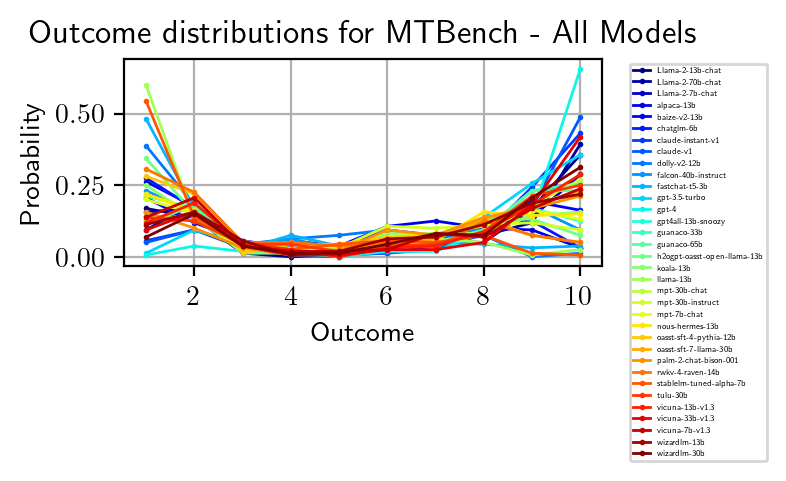

In [12]:
fig = plt.figure(figsize=(4,2))
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(all_dists)))

for i,row in enumerate(all_dists.iterrows()):
    plt.plot(row[1], label=row[0], marker='o', markersize = 1, linewidth=1,
             color=colors[i])

plt.legend(fontsize =3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Outcome')
plt.ylabel('Probability')
plt.title('Outcome distributions for MTBench - All Models')
plt.grid()
plt.tight_layout()

In [8]:
rlvnt_models = [f'Llama-2-{i}b-chat' for i in ['7', '13', '70']]
# efficiency taken from https://huggingface.co/spaces/optimum/llm-perf-leaderboard
# in units of tokens/kWH
#efficiency = [154_559, 120_772, 52_083] # 106_723,151_745]
# show costs in units of $/1M tokens
# doll_per_token taken from conervative energy cost estimates in the U.S.
doll_per_token = 0.105
costs = np.array([1.73, 2.3, 6.1]) * doll_per_token
costs_rob = np.array([0, 0, costs[-1] - costs[0]])
cost_dct = dict(zip(rlvnt_models, costs))
cost_dct_rob = dict(zip(rlvnt_models, costs_rob))
for mdl, cst in cost_dct.items():
    print(f'Model: {mdl}, Cost: {cst:.3f} $/1M tokens')
for mdl, cst in cost_dct_rob.items():
    print(f'Model: {mdl}, Robust Cost: {cst:.3f} $/1M tokens')

Model: Llama-2-7b-chat, Cost: 0.182 $/1M tokens
Model: Llama-2-13b-chat, Cost: 0.241 $/1M tokens
Model: Llama-2-70b-chat, Cost: 0.640 $/1M tokens
Model: Llama-2-7b-chat, Robust Cost: 0.000 $/1M tokens
Model: Llama-2-13b-chat, Robust Cost: 0.000 $/1M tokens
Model: Llama-2-70b-chat, Robust Cost: 0.459 $/1M tokens



## Analysis

In [17]:
#Non-monotone contracts
contract_df, c, t_opt_non_monotone = contract_setting.solve_contract(rlvnt_models, costs)
F = contract_df.to_numpy()
contract_df_rob, c_rob, t_opt_non_monotone_rob = contract_setting.solve_contract(rlvnt_models, costs_rob)
F_rob = contract_df.to_numpy()

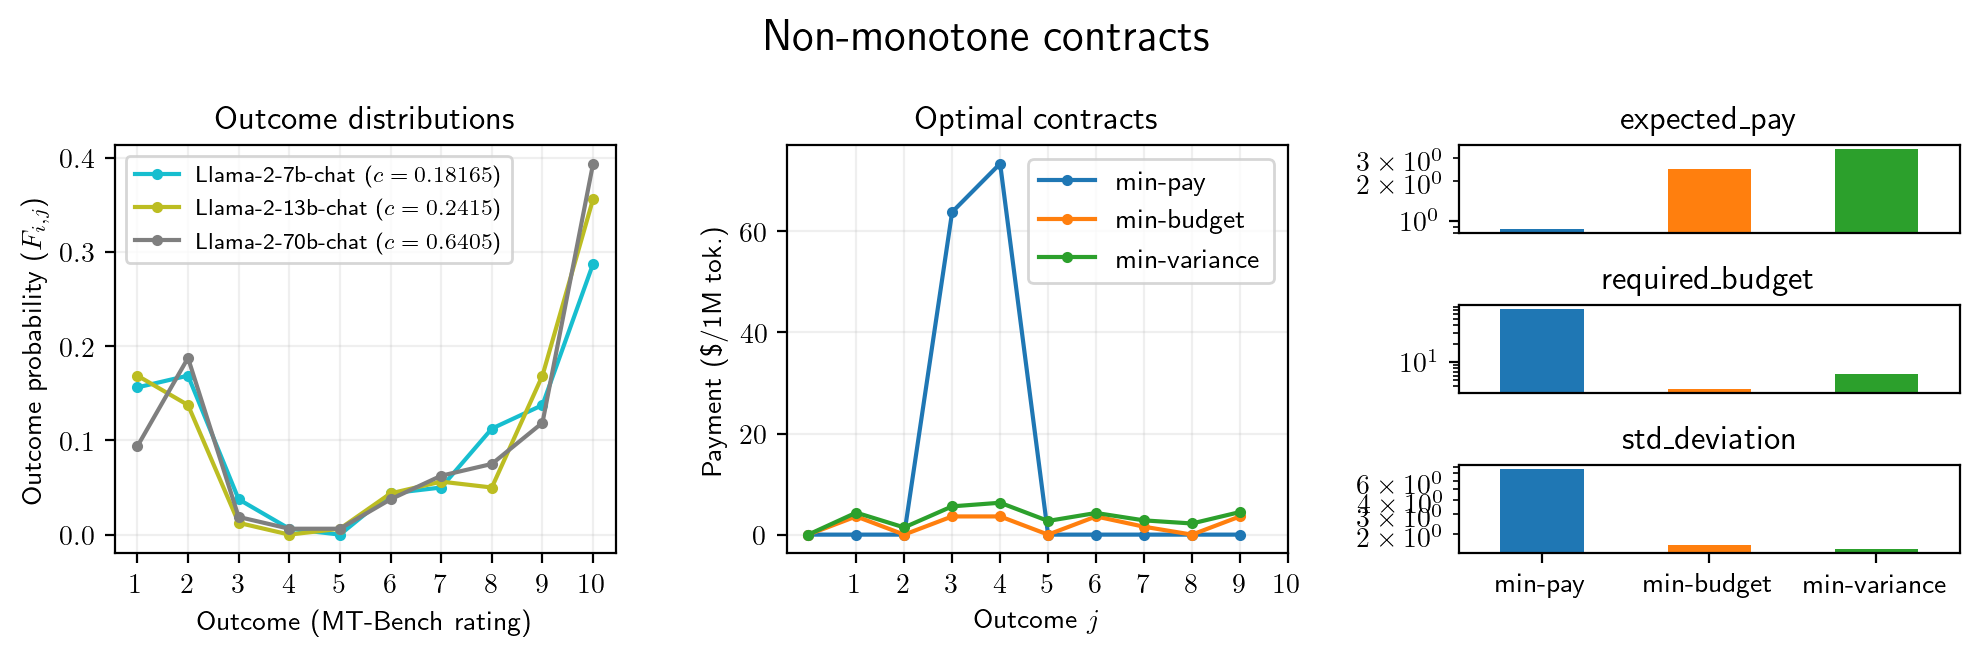

In [16]:
fig = plt.figure(figsize=(10,3.3),tight_layout={'w_pad':2})
fig.suptitle('Non-monotone contracts', fontsize=16)
ax = fig.add_subplot(1,3,1)
for i in range(len(F)):
    ax.plot(
        contract_df.columns,
        F[i],
        '.-',
        color=list(matplotlib.colors.TABLEAU_COLORS)[-(i+1)],
        label=f'{contract_df.index[i]} ($c={c[i]:g}$)',
        # label=f'$F_{{{i+1}j}}$ ($c_{{{i+1}}}={c[i]}$)',
    )
ax.set(
    title='Outcome distributions',
    xlabel='Outcome (MT-Bench rating)',
    ylabel='Outcome probability ($F_{i,j}$)',
    xticks = np.arange(1,11,1),
)
ax.legend(fontsize = 8)
ax.grid(alpha=0.2)
ax = fig.add_subplot(1,3,2)
for i,(contract_name, t) in enumerate(t_opt_non_monotone.items()):
    ax.plot(
        t,
        '.-',
        label=contract_name,
    )
ax.legend()
ax.set(
    title='Optimal contracts',
    xlabel='Outcome $j$',
    ylabel='Payment (\$/1M tok.)',
    xticks = np.arange(1,11,1),
)
ax.grid(alpha=0.2)

axs = [
    fig.add_subplot(3,3,3),
    fig.add_subplot(3,3,6),
    fig.add_subplot(3,3,9),
]

contract_stats_df = (
    pd.Series(t_opt_non_monotone)
    .apply(lambda t: statcontracts.contract_objectives(F,c,t))
    .apply(pd.Series)
)

for ax, (i,row) in zip(axs,contract_stats_df.transpose().iterrows()):
    row.plot.bar(
        ax=ax,
        logy=True,
        color=list(matplotlib.colors.TABLEAU_COLORS),
    )
    if i!='std_deviation':
        ax.set_xticks([])
    else:
        ax.tick_params(axis='x', labelrotation=0)
    ax.set_title(i)



### Cost-aware vs Cost-robust contracts

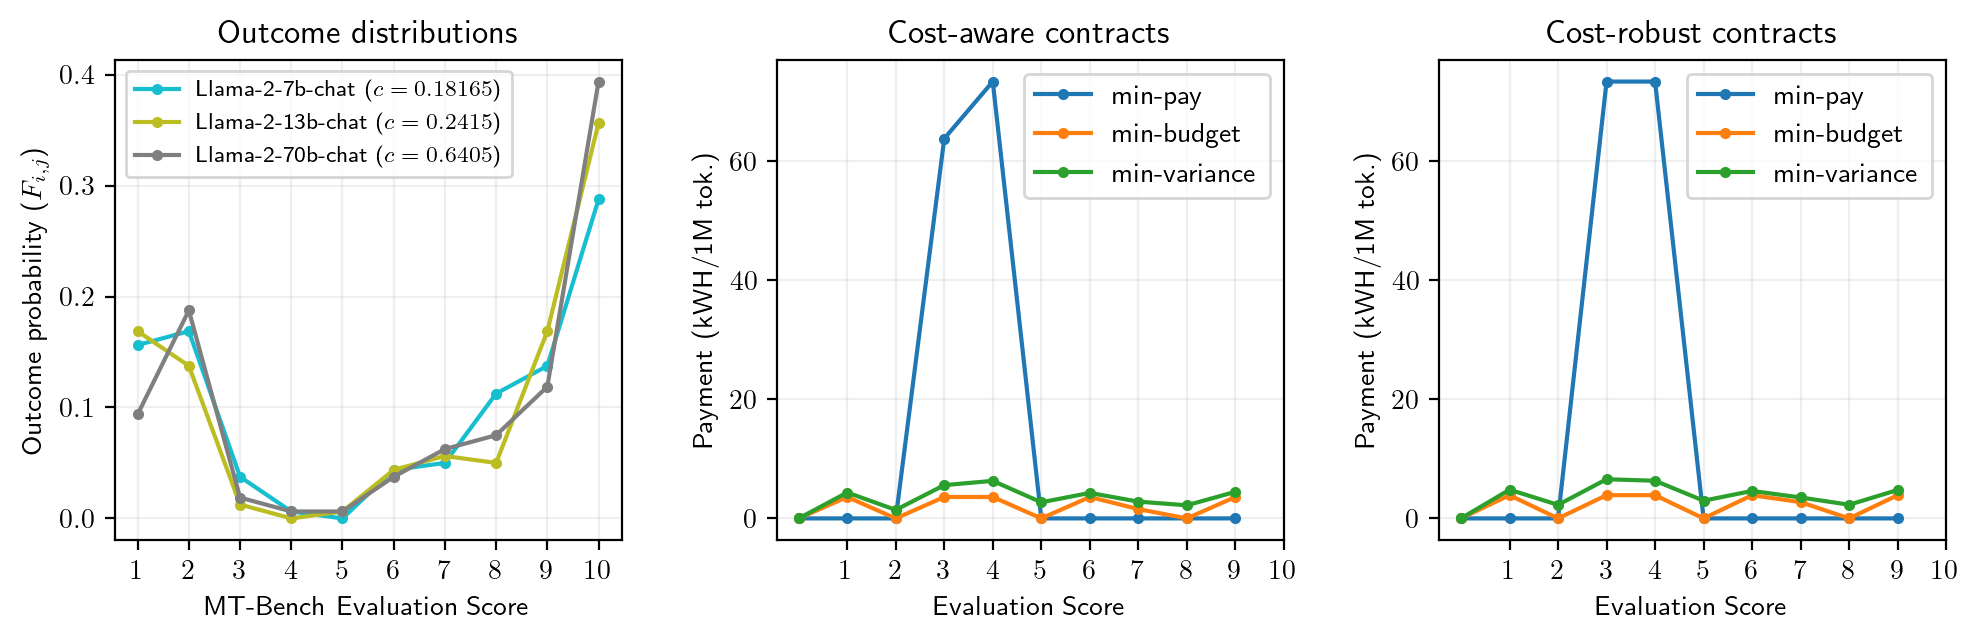

In [18]:
fig = plt.figure(figsize=(10,3.3),tight_layout={'w_pad':2})

ax = fig.add_subplot(1,3,1)
for i in range(len(F_rob)):
    ax.plot(
        contract_df.columns,
        F[i],
        '.-',
        color=list(matplotlib.colors.TABLEAU_COLORS)[-(i+1)],
        label=f'{contract_df.index[i]} ($c={c[i]:g}$)',
        # label=f'$F_{{{i+1}j}}$ ($c_{{{i+1}}}={c[i]}$)',
    )
ax.set(
    title='Outcome distributions',
    xlabel='MT-Bench Evaluation Score',
    ylabel='Outcome probability ($F_{i,j}$)',
    xticks = np.arange(1,11,1),
)
ax.legend(fontsize = 8)
ax.grid(alpha=0.2)

ax = fig.add_subplot(1,3,2)
for i,(contract_name, t) in enumerate(t_opt_non_monotone.items()):
    ax.plot(
        t,
        '.-',
        label=contract_name,
    )
ax.legend()
ax.set(
    title='Cost-aware contracts',
    xlabel='Evaluation Score',
    ylabel='Payment (kWH/1M tok.)',
    xticks = np.arange(1,11,1),
)
ax.grid(alpha=0.2)

ax = fig.add_subplot(1,3,3)
for i,(contract_name, t) in enumerate(t_opt_non_monotone_rob.items()):
    ax.plot(
        t,
        '.-',
        label=contract_name,
    )
ax.legend()
ax.set(
    title='Cost-robust contracts',
    xlabel='Evaluation Score',
    ylabel='Payment (kWH/1M tok.)',
    xticks = np.arange(1,11,1),
)
ax.grid(alpha=0.2)


### Monotone and threshold contracts

In [19]:
optim = statcontracts.optimize.ThresholdContractOptimizer()

contract_df, c, t_opt_mon_aware = contract_setting.solve_contract(rlvnt_models, costs, monotone=True)
#F = contract_df.to_numpy()
contract_df_rob, c_rob, t_opt_mon_rob = contract_setting.solve_contract(rlvnt_models, costs_rob,monotone=True)
#F_rob = contract_df.to_numpy()
t_opt_thresh_aware = optim.solve(F,c)
t_opt_thresh_rob = optim.solve(F,c_rob)

/var/folders/_5/djxdk8xj285d3qgw7km9wmw80000gp/T/ipykernel_3143/4084757518.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(
/var/folders/_5/djxdk8xj285d3qgw7km9wmw80000gp/T/ipykernel_3143/4084757518.py:43: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(


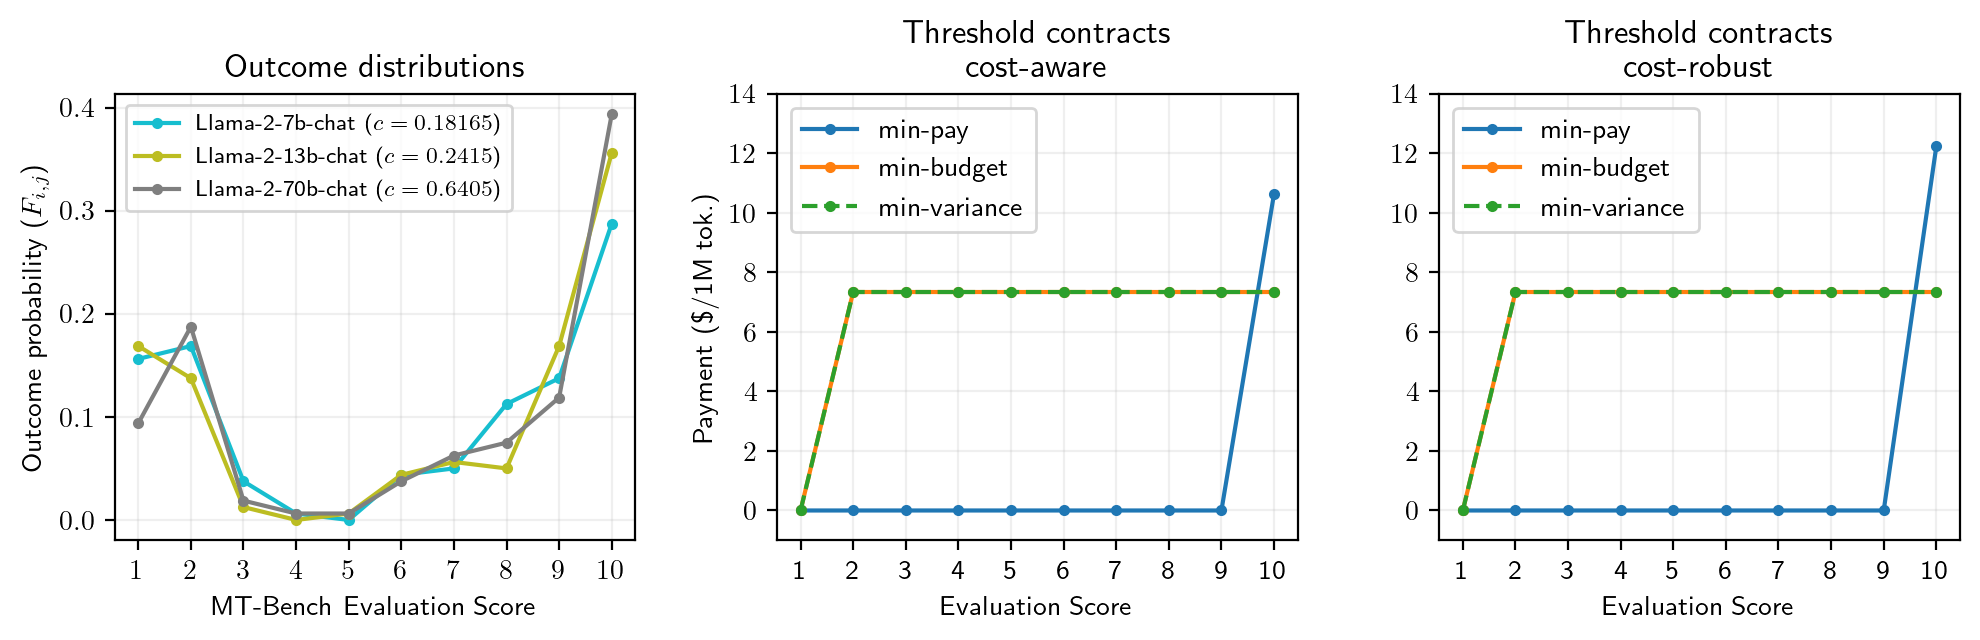

In [20]:
fig = plt.figure(figsize=(10, 3.3), tight_layout={'w_pad': 2})

ax = fig.add_subplot(1, 3, 1)
for i in range(len(F_rob)):
    ax.plot(
        contract_df.columns,
        F[i],
        '.-',
        color=list(matplotlib.colors.TABLEAU_COLORS)[-(i + 1)],
        label=f'{contract_df.index[i]} ($c={c[i]:g}$)',
        # label=f'$F_{{{i+1}j}}$ ($c_{{{i+1}}}={c[i]}$)',
    )
ax.set(
    title='Outcome distributions',
    xlabel='MT-Bench Evaluation Score',
    ylabel='Outcome probability ($F_{i,j}$)',
    xticks=np.arange(1, 11, 1),
)
ax.legend(fontsize=8)
ax.grid(alpha=0.2)

ax = fig.add_subplot(1, 3, 2)
for i, (contract_name, t) in enumerate(t_opt_thresh_aware.items()):
    ax.plot(
        t,
        '.-',
        label=contract_name,
        linestyle= 'dashed' if i==2 else 'solid',
    )
ax.legend()
ax.set(
    title='Threshold contracts \n cost-aware',
    xlabel='Evaluation Score',
    ylabel='Payment (\$/1M tok.)',
)
ax.set_xticks(np.arange(0, 10, 1),labels= np.arange(1, 11, 1))
#ax.set_yticks(np.arange(0,14,2))
ax.set_ylim(-1,14)
ax.grid(alpha=0.2)

ax = fig.add_subplot(1, 3, 3)
for i, (contract_name, t) in enumerate(t_opt_thresh_rob.items()):
    ax.plot(
        t,
        '.-',
        label=contract_name,
        linestyle='dashed' if i==2 else 'solid',
    )
ax.legend()
ax.set(
    title='Threshold contracts \n cost-robust',
    xlabel='Evaluation Score',
    #ylabel='Payment (\$/1M tok.)',

)
ax.set_xticks(np.arange(0, 10, 1),labels= np.arange(1, 11, 1))
ax.set_ylim(-1,14)
#ax.set_yticks([])
ax.grid(alpha=0.2)

### Save all contracts to a json file

In [25]:
#Monotone contracts
_, _, t_opt_monotone_aware = contract_setting.solve_contract(rlvnt_models, costs, monotone=True)
_, _, t_opt_monotone_rob = contract_setting.solve_contract(rlvnt_models, costs_rob,monotone=True)

#Threshold contracts
optim = statcontracts.optimize.ThresholdContractOptimizer()
t_opt_thresh_aware = optim.solve(F,c)
t_opt_thresh_rob = optim.solve(F,c_rob)

In [35]:
all_contracts = {
    't_opt_thresh_aware': {k: list(v) for k,v in t_opt_thresh_aware.items()},
    't_opt_thresh_rob': {k: list(v) for k,v in t_opt_thresh_rob.items()},
    't_opt_monotone_aware': {k: list(v) for k,v in t_opt_monotone_aware.items()},
    't_opt_monotone_rob': {k: list(v) for k,v in t_opt_monotone_rob.items()}
}
results_directory = './results'
# save the contracts dictionary to a new json file in the results directory
with open(f'{results_directory}/mtbench_contracts.json', 'w') as f:
    json.dump(all_contracts, f)


In [39]:
#dave the data distributions to a csv file
pd.DataFrame(F).to_csv(f'{results_directory}/mtbench_F.csv',index=False)